## Experiments on learning path of CIFAR10 (both clean and noisy labels)

(sorry for leaving the local path I used in my laptop... there are some explanations for these variables, so you can change the files)

In [1]:
import os
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.tri as tri
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd

CIFAR10_Train = torchvision.datasets.CIFAR10('E:/DATASET', train=True, download=False, transform=transforms.ToTensor()) # Just dataset

### Part I: Observe the behavior of 1000 wrong-labels-samples

In [2]:
# For learning path of flipped labels
# You can run main_gen_path.py and save the path in the specific path
MAIN_PATH = './save_paths/noisy_1000'
path1 = os.path.join(MAIN_PATH,'OHT_PATH_ALL.npy')
path2 = os.path.join(MAIN_PATH,'OHT_PATH_END.npy')
path3 = os.path.join(MAIN_PATH,'track_y.npy')
path4 = os.path.join(MAIN_PATH,'trackn_y.npy')

TRACK_TRAIN_PATH = np.load(path1)
TRACK_TRAIN_END = np.load(path2)
track_y = np.load(path3)
track_ny = np.load(path4)

print(TRACK_TRAIN_PATH.shape)    #Record the learning path at the end of each update
print(TRACK_TRAIN_END.shape)     #Record the learning path at the end of each epoch
print(track_y.shape)             #True y of these 1000 samples
print(track_ny.shape)            #Noisy y of these 1000 samples

(1000, 6240, 10)
(1000, 100, 10)
(1000,)
(1000,)


In [3]:
# For learning path of clean labels
OTHER_PATH = './save_paths/clean_OHT_path.npy'
PATH_BATH = np.load(OTHER_PATH)
print(PATH_BATH.shape)
print(TRACK_TRAIN_PATH.shape)

# As PATH_BATH only record 200 times but TRACK_TRAIN_PATH record 6240 samples, calculate the following ratio to balance the integral
ratio = TRACK_TRAIN_PATH.shape[1]/PATH_BATH.shape[1]

(50000, 200, 10)
(1000, 6240, 10)


### Calculate the difficulty of each sample, compare zig-zagness of wrong/clean labels

In [4]:
combine_difficulity = np.zeros((1000,4))
tmp_integral = TRACK_TRAIN_PATH.sum(1)
combine_difficulity[:,3] = track_y
for i in range(1000):
  top1_idx = tmp_integral[i,:].argsort()[-1]
  top2_idx = tmp_integral[i,:].argsort()[-4:-1]
  combine_difficulity[i,0] = i
  combine_difficulity[i,1] = tmp_integral[i,top1_idx]
  combine_difficulity[i,2] = tmp_integral[i,top2_idx].sum()
tmp_max1 = combine_difficulity[:,1].max()
tmp_max2 = combine_difficulity[:,2].max()
combine_difficulity[:,1] = 1-combine_difficulity[:,1]/tmp_max1
combine_difficulity[:,2] = combine_difficulity[:,2]/tmp_max2
combine_difficulity = pd.DataFrame(combine_difficulity,columns=['index','integral','zigzagness','class'])
combine_difficulity_sort=combine_difficulity.sort_values('zigzagness',ascending=False)

In [5]:
other_combine_difficulity = np.zeros((49000,3))
other_tmp_integral = PATH_BATH.sum(1)
for i in range(49000):
  top1_idx = other_tmp_integral[i,:].argsort()[-1]
  top2_idx = other_tmp_integral[i,:].argsort()[-4:-1]
  other_combine_difficulity[i,0] = i
  other_combine_difficulity[i,1] = other_tmp_integral[i,top1_idx]
  other_combine_difficulity[i,2] = other_tmp_integral[i,top2_idx].sum()
other_combine_difficulity[:,1] = 1-other_combine_difficulity[:,1]/tmp_max1*ratio
other_combine_difficulity[:,2] = other_combine_difficulity[:,2]/tmp_max2*ratio
other_combine_difficulity = pd.DataFrame(other_combine_difficulity,columns=['index','integral','zigzagness'])

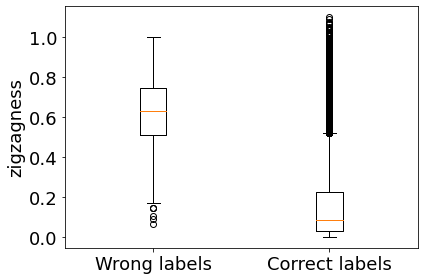

In [6]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.boxplot([combine_difficulity['zigzagness'],other_combine_difficulity['zigzagness']],notch=False)
ax.set_ylabel('zigzagness') 
plt.setp(ax, xticks=[1,2],xticklabels=['Wrong labels', 'Correct labels'])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
fig.tight_layout()

### Observe how filtering can help to correct more labels

In [7]:
ALL_POINTS = TRACK_TRAIN_PATH.shape[1]
smoth_ratio=0.99
TRACK_TRAIN_PATH_SMOTH = np.zeros(TRACK_TRAIN_PATH.shape)
for i in range(TRACK_TRAIN_PATH.shape[1]):
    if i==0:
        TRACK_TRAIN_PATH_SMOTH[:,i,:]=TRACK_TRAIN_PATH[:,i,:]
    else:
        TRACK_TRAIN_PATH_SMOTH[:,i,:]=smoth_ratio*TRACK_TRAIN_PATH_SMOTH[:,i-1,:]+TRACK_TRAIN_PATH[:,i,:]*(1-smoth_ratio)

In [8]:
pred_eskd, pred_filt = [],[]
for i in range(TRACK_TRAIN_PATH.shape[1]):
    pred_eskd.append((TRACK_TRAIN_PATH[:,i,:].argmax(1)==track_y).sum())
    pred_filt.append((TRACK_TRAIN_PATH_SMOTH[:,i,:].argmax(1)==track_y).sum())

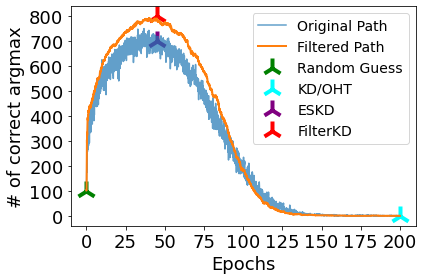

In [9]:
fig, ax1 = plt.subplots(nrows=1,ncols=1) 
x = np.arange(0,ALL_POINTS,1)*200/ALL_POINTS
ax1.plot(x, pred_eskd,label='Original Path',alpha=0.7)
ax1.plot(x, pred_filt,label='Filtered Path',linewidth=2)
ax1.scatter(0,100,label='Random Guess',color='green',marker='2',s=400,linewidth=4)
ax1.scatter(200,0,label='KD/OHT',color='cyan',marker='2',s=400,linewidth=4)
ax1.scatter(45,700,label='ESKD',color='purple',marker='2',s=400,linewidth=4)
ax1.scatter(45,800,label='FilterKD',color='red',marker='2',s=400,linewidth=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('# of correct argmax')
ax1.legend(fontsize=14)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(18)
fig.tight_layout()

### Observe how filtering helps in CIFAR10H

In [10]:
def KL_distance_q_p(q,p):
    return nn.KLDivLoss(reduction='batchmean')(q.log(), p).detach()
  
def L2_distance_q_p(q, p):
    dist = (nn.MSELoss(reduction='mean')(q.reshape(-1,1),p.reshape(-1,1)))**2#torch.dist(q.reshape(-1,1),p.reshape(-1,1),p=2)#
    return dist.detach()

def y_to_oht(label):
    label_oht = torch.zeros(label.shape[0],10)
    label_oht.scatter_(1,label,1)
    label_oht = label_oht.float()
    return label_oht

x = np.arange(0,10000,1)

In [11]:
path = './save_paths/cifar10h/'
PATH_TRAIN_COARSE = np.load(path+ 'PATH_ALL_COARSE.npy')
PATH_TRAIN_FINE = np.load(path+ 'PATH_ALL_FINE.npy')
print(PATH_TRAIN_COARSE.shape)
print(PATH_TRAIN_FINE.shape)

pred = PATH_TRAIN_COARSE[:,-1,:].argmax(-1)
hum_prob = torch.tensor(np.load(path+ 'cifar10h-probs.npy'))

(10000, 200, 10)
(10000, 2500, 10)


In [12]:
SMTH_TRAIN_COARSE = np.zeros(PATH_TRAIN_COARSE.shape)
tmp_train_coarse = PATH_TRAIN_COARSE[:,0,:]
SMTH_TRAIN_COARSE[:,0,:] = tmp_train_coarse
for i in range(200-1):
    tmp_train_coarse = PATH_TRAIN_COARSE[:,i+1,:]*0.1 + tmp_train_coarse*0.9
    SMTH_TRAIN_COARSE[:,i+1,:] = tmp_train_coarse

SMTH_TRAIN_FINE = np.zeros(PATH_TRAIN_FINE.shape)
tmp_train = PATH_TRAIN_FINE[:,0,:]
SMTH_TRAIN_FINE[:,0,:] = tmp_train
for i in range(PATH_TRAIN_FINE.shape[1]-1):
    tmp_train = PATH_TRAIN_FINE[:,i+1,:]*0.01 + tmp_train*0.99
    SMTH_TRAIN_FINE[:,i+1,:] = tmp_train

In [13]:
# ---------- Calculate the difficulty and sort the samples
tmp = PATH_TRAIN_COARSE.sum(1).argsort(1)[x,-2]                     
zigzag_rank = PATH_TRAIN_COARSE[x,:,tmp].sum(1).argsort()
tmp = PATH_TRAIN_COARSE.sum(1).argsort(1)[x,-1]                     
integral_rank = PATH_TRAIN_COARSE[x,:,tmp].sum(1).argsort()[::-1]
hum_rank = np.array(hum_prob.var(1).argsort())[::-1]

In [14]:
def get_difficulty_mask(metric='zigzag', n_sample=100, path=SMTH_TRAIN_COARSE):
    x = np.arange(0,10000,1)
    if metric=='zigzag':    
        zigzag_pred = path.sum(1).argsort(1)[x,-2]                     # class of the 2nd highest predictions
        most_hard = path[x,:,zigzag_pred].sum(1).argsort()[-n_sample:]   # calculate zigzagness and select highest 1000 samples
    elif metric=='integral':
        zigzag_pred = path.sum(1).argsort(1)[x,-1]                     # class of the 1st highest predictions
        most_hard = path[x,:,zigzag_pred].sum(1).argsort()[:n_sample]   # calculate zigzagness and select highest 1000 samples
    elif metric=='zigzag_least':
        zigzag_pred = path.sum(1).argsort(1)[x,-2]                     # class of the 1st highest predictions
        most_hard = path[x,:,zigzag_pred].sum(1).argsort()[:n_sample]   # calculate zigzagness and select highest 1000 samples
    elif metric=='hum_var':
        most_hard = hum_prob.var(1).argsort()[:n_sample]
    zigzag_mask = np.zeros((10000,1))
    zigzag_mask[most_hard]=1
    zigzag_mask = zigzag_mask>0
    return zigzag_mask.squeeze(), most_hard

def get_dist_to_hum(mask, dist_type='kl',tgt_pred='hum'):
    if dist_type=='kl':
        dist_fun = KL_distance_q_p
    elif dist_type=='l2':
        dist_fun = L2_distance_q_p
    gap_kdoht, gap_filtoht = [], []
    if tgt_pred=='hum':
        tgt_prob = hum_prob
    elif tgt_pred=='oht':
        tgt_prob = y_to_oht(torch.tensor(pred).unsqueeze(1))
    for i in range(200):
        v1 = PATH_TRAIN_COARSE[mask,i,:]
        v2 = SMTH_TRAIN_COARSE[mask,i,:]
        gap_kdoht.append(dist_fun(torch.tensor(v1),tgt_prob[mask]).item())
        gap_filtoht.append(dist_fun(torch.tensor(v2),tgt_prob[mask]).item())
    return np.array(gap_kdoht), np.array(gap_filtoht)

In [15]:
zigzag_mask, most_zigzag = get_difficulty_mask('zigzag', n_sample=1000, path=SMTH_TRAIN_COARSE)
integral_mask, most_integral = get_difficulty_mask('zigzag_least',n_sample=10000,path=SMTH_TRAIN_COARSE)
hum_mask, most_hum = get_difficulty_mask('hum_var',n_sample=1000)

gap_kl_kdhum, gap_kl_filthum = get_dist_to_hum(zigzag_mask,'kl')
gap_kl_kdoht, gap_kl_filtoht = get_dist_to_hum(zigzag_mask,'kl','oht')

gap_kl_kdhum_hum, gap_kl_filthum_hum = get_dist_to_hum(hum_mask,'kl')
gap_kl_kdoht_hum, gap_kl_filtoht_hum = get_dist_to_hum(hum_mask,'kl','oht')

gap_kl_kdhum_other, gap_kl_filthum_other = get_dist_to_hum(integral_mask,'kl')
gap_kl_kdoht_other, gap_kl_filtoht_other = get_dist_to_hum(integral_mask,'kl','oht')

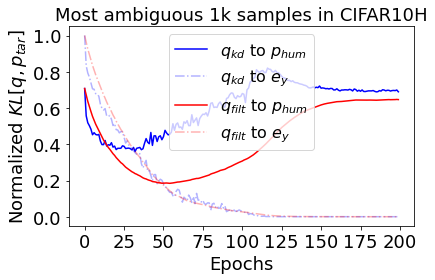

In [16]:
fig, ax1 = plt.subplots(figsize=(6,4)) 
ax1.plot(gap_kl_kdhum_hum/2.5,'b-',label='$q_{kd}$ to $p_{hum}$')
ax1.plot(gap_kl_kdoht_hum/2.5,'b-.',alpha=0.3,label='$q_{kd}$ to $e_y$')
ax1.plot(gap_kl_filthum_hum/2.5,'r-',label='$q_{filt}$ to $p_{hum}$')
ax1.plot(gap_kl_filtoht_hum/2.5,'r-.',alpha=0.3,label='$q_{filt}$ to $e_y$')
ax1.set_title('Most ambiguous 1k samples in CIFAR10H',fontsize=18)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Normalized $KL[q,p_{tar}]$')
ax1.legend(fontsize=16)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(18)
fig.tight_layout()

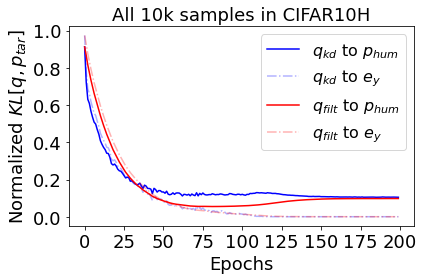

In [17]:
fig, ax1 = plt.subplots(figsize=(6,4)) 
ax1.plot(gap_kl_kdhum_other/2.5,'b-',label='$q_{kd}$ to $p_{hum}$')
ax1.plot(gap_kl_kdoht_other/2.5,'b-.',alpha=0.3,label='$q_{kd}$ to $e_y$')
ax1.plot(gap_kl_filthum_other/2.5,'r-',label='$q_{filt}$ to $p_{hum}$')
ax1.plot(gap_kl_filtoht_other/2.5,'r-.',alpha=0.3,label='$q_{filt}$ to $e_y$')
ax1.set_title('All 10k samples in CIFAR10H',fontsize=18)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Normalized $KL[q,p_{tar}]$')
ax1.legend(fontsize=16)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(18)
fig.tight_layout()

## Part II: Visualize figures and paths

In [18]:
TRACK_TRAIN_PATH = TRACK_TRAIN_PATH[:,::5,:]      # Downsample to make the computer safe...
ALL_POINTS = TRACK_TRAIN_PATH.shape[1]
ESEP = int(ALL_POINTS*(50/200))

#### The code for generating zig-zag fashion path, similar with that in ToyGaussian examples

In [19]:
def p_to_xy(p,corners):
 # ==== p must have shape (x,3) =====
 x = p[:,0]*corners[0,0]+p[:,1]*corners[1,0]+p[:,2]*corners[2,0]
 y = p[:,0]*corners[0,1]+p[:,1]*corners[1,1]+p[:,2]*corners[2,1]
 return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=1).squeeze()
 
def p_to_xy_path(p,corners):
 # ==== p must have shape (id,x,3) =====
 x = p[:,:,0]*corners[0,0]+p[:,:,1]*corners[1,0]+p[:,:,2]*corners[2,0]
 y = p[:,:,0]*corners[0,1]+p[:,:,1]*corners[1,1]+p[:,:,2]*corners[2,1]
 return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=-1).squeeze()
 
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
def smooth_path(origin_path, alpha=0.9):
   for i in range(origin_path.shape[1]):
       if i==0:
           smooth_path = origin_path[:,0,:].unsqueeze(1)
           previous = smooth_path
       else:
           tmp = origin_path[:,i,:].unsqueeze(1)*(1-alpha) + previous*alpha
           smooth_path = torch.cat((smooth_path,tmp),dim=1)
           previous = tmp
   return smooth_path
 
def draw_one_pic_y_ny(path_id, smooth_level=0.9,highlight_ep=50, start_end=[0,100],
                      path_type='train', ax=None,legend=True,title=None):
   '''
       Only works for train path and test path with correct predictions
   '''
   if ax is None:
       figure, ax = plt.subplots(1,1,figsize=(5,5))
   if path_type=='track':
       origin_path = TRACK_TRAIN_PATH[path_id,:,:]
   elif path_type=='track_end':
       origin_path = TRACK_TRAIN_PATH[path_id,:,:]
   elif path_type=='clean_label':
       origin_path = PATH_BATH[path_id,:,:]
  
   left_corn = np.argsort(origin_path[-1,:])[-1]#np.argsort(origin_path[:,:].sum(0))[-1]#
   kk=2
   righ_corn = np.argsort(origin_path[:,:].sum(0))[-kk]
   while(righ_corn==left_corn):
       righ_corn = np.argsort(origin_path[:,:].sum(0))[-kk]#np.argsort(origin_path[-1,:])[-2]#
       kk+=1
 
   start_ep, end_ep = start_end[0], start_end[1]
   merged_path = np.zeros((origin_path.shape[0],3))
   top1_idx = left_corn
   topx_idx = righ_corn
 
   merged_path[:,0] = origin_path[:,top1_idx]
   merged_path[:,1] = origin_path[:,topx_idx]
   merged_path[:,2] = np.ones(origin_path.shape[0])-origin_path[:,top1_idx]-origin_path[:,topx_idx]
   merged_path = torch.tensor(merged_path).unsqueeze(0)
 
   merged_path_smth = smooth_path(merged_path,smooth_level)
   path_to_draw = p_to_xy_path(merged_path,corners)
   path_to_draw_smth = p_to_xy_path(merged_path_smth,corners)
 
   highlight_idx = highlight_ep
   colors = range(end_ep-start_ep)
   ax.triplot(triangle)
   ax.axis('off')
   ax.axis('equal')
 
   ax.scatter(path_to_draw[start_ep:end_ep,0],path_to_draw[start_ep:end_ep,1],c=colors,cmap=plt.cm.Blues, edgecolors='none', s=40,alpha=0.8)
   ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='blue',label='Origin Path',s=60,alpha=0.5)
   ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='red',label='Smoothed Path',s=60,alpha=0.5)
   ax.scatter(path_to_draw_smth[start_ep:end_ep,0],path_to_draw_smth[start_ep:end_ep,1],c=colors,cmap=plt.cm.Reds, edgecolors='none', s=40,alpha=0.8)
   ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='green',label='Start',s=100,alpha=0.8,marker='D')
   ax.scatter(path_to_draw_smth[highlight_idx,0],path_to_draw_smth[highlight_idx,1], color='red',label='Early Stopped',s=300,alpha=0.8,marker='+')
 
   if legend:
       ax.legend()
   if title is not None:
       ax.text(0.37,-0.1,title,fontsize=16)
   #ax.text(x=0,y=0,s='OHT y\n'+classes[left_corn],ha='right',va='center',fontsize=14,weight='bold')
   #ax.text(x=1,y=0,s='True y'+'\n'+classes[righ_corn],ha='left',va='center',fontsize=14,weight='bold')
   #ax.text(x=0.5,y=0.86,s='Others', ha='center',va='bottom',fontsize=14,weight='bold')

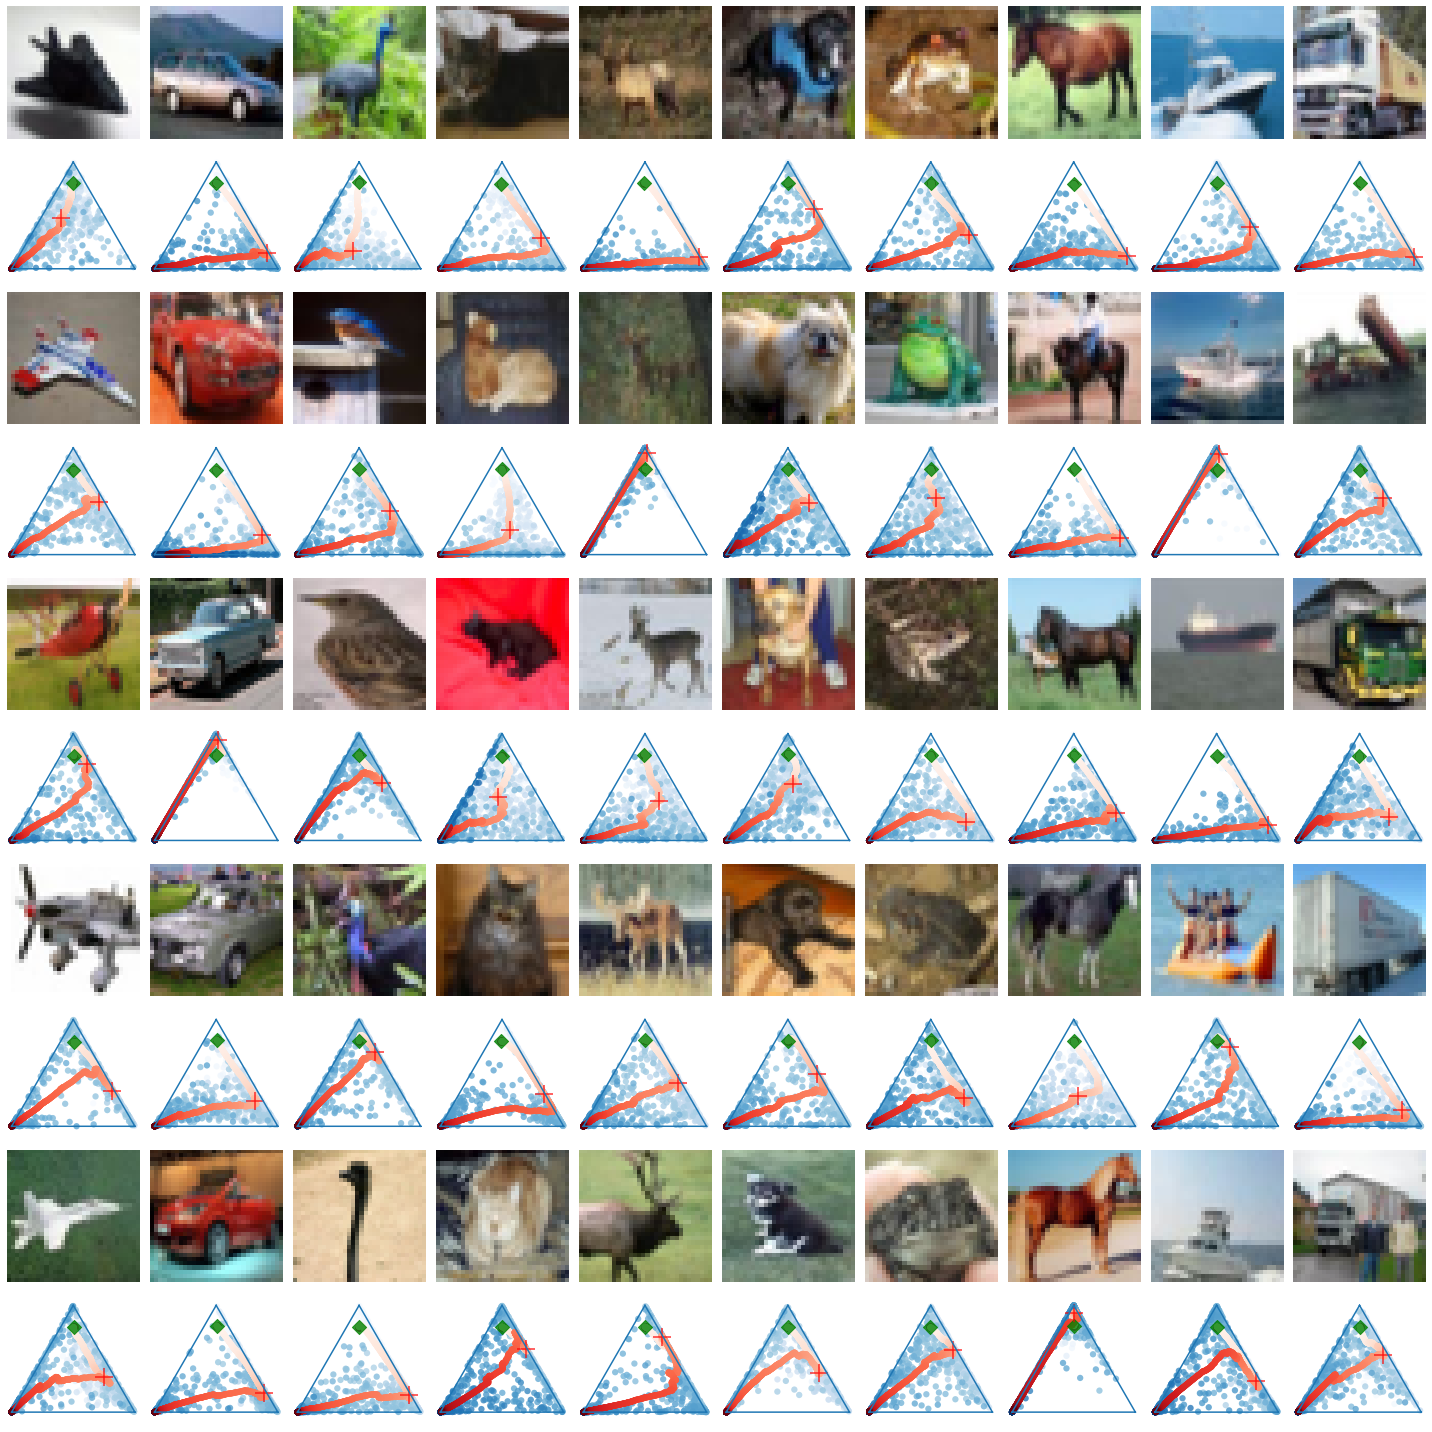

In [20]:
figure, ax = plt.subplots(10,10,figsize=(20,20))
for c in range(10):   # Class
    for r in range(5):  # Sample
        smp_id = r*10+c
        class_mask = combine_difficulity['class']==(c)
        img_idx = int(list(combine_difficulity[class_mask]['index'])[r])
        img, clas = CIFAR10_Train.__getitem__(img_idx)
        ax[2*r][c].imshow(img.transpose(0,2).transpose(0,1))
        ax[2*r][c].axis('off') 
        draw_one_pic_y_ny(img_idx, smooth_level = 0.99, highlight_ep=ESEP, start_end=[0,ALL_POINTS], path_type='track',ax=ax[2*r+1][c],legend=False)
figure.tight_layout()

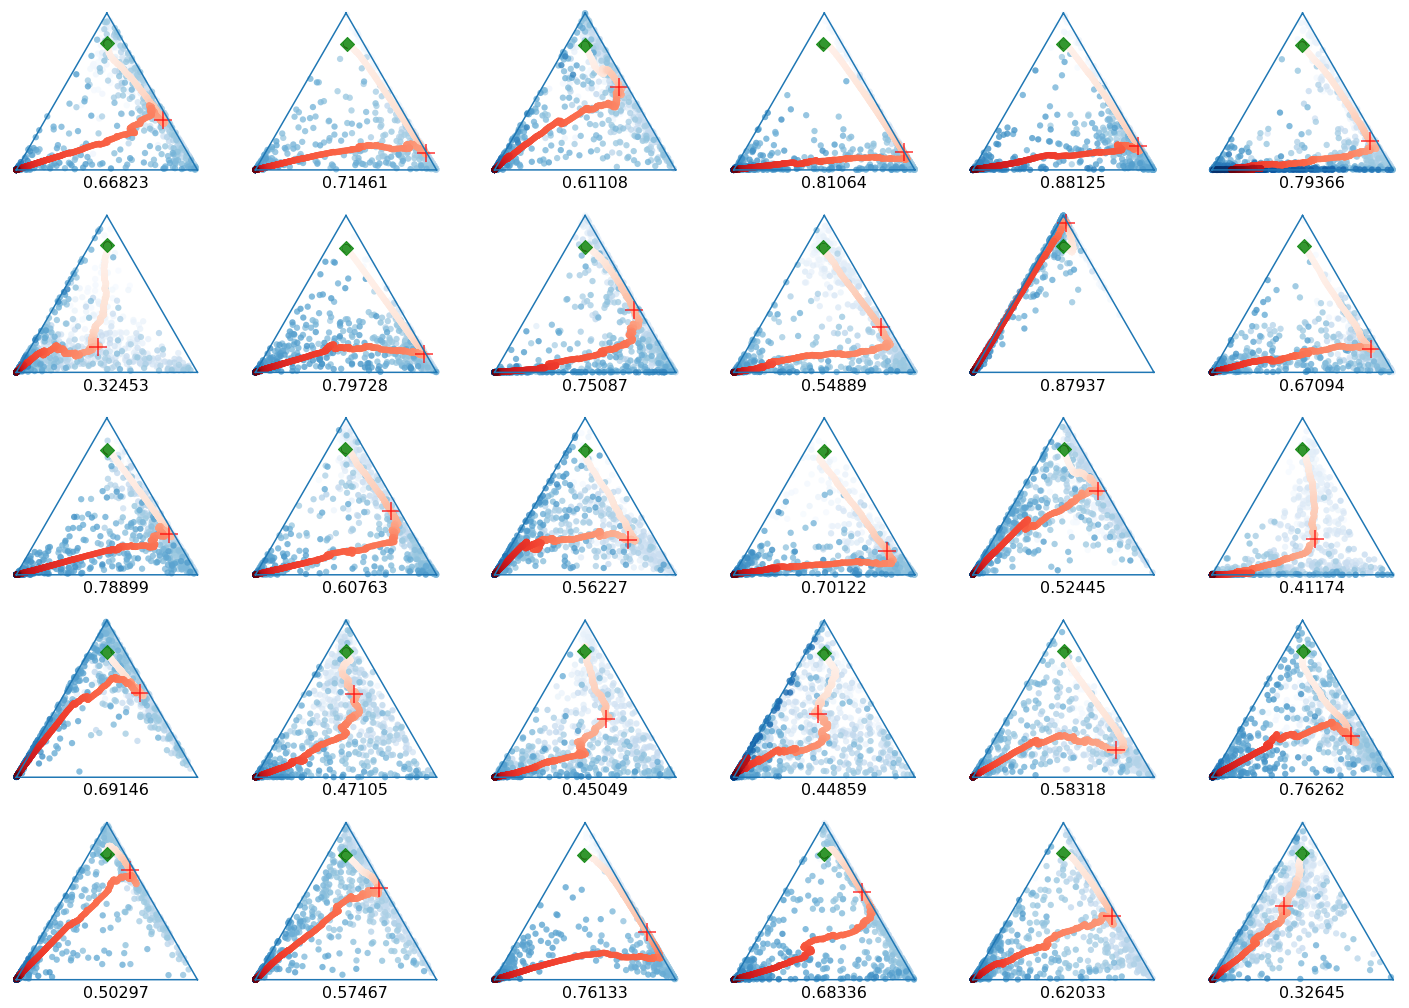

In [21]:
figure, ax = plt.subplots(5,6,figsize=(25,18))
for i in range(5):
  for j in range(6):
    idx = j+i*6
    path_id = idx
    zigzag = combine_difficulity['zigzagness'][path_id].round(5)
    draw_one_pic_y_ny(path_id, smooth_level = 0.99, highlight_ep=ESEP,start_end=[0,ALL_POINTS], path_type='track',ax=ax[i][j],legend=False,title=str(zigzag))

## For training on clean labels

In [22]:
Train_ID_Y = PATH_BATH[:,-1,:].argmax(1)          # Remember we have 100% training accuracy, so we get true y in this way
other_combine_difficulity = np.zeros((49000,4))
other_tmp_integral = PATH_BATH.sum(1)
other_combine_difficulity[:,3] = Train_ID_Y[:49000]
for i in range(49000):
  top1_idx = other_tmp_integral[i,:].argsort()[-1]
  top2_idx = other_tmp_integral[i,:].argsort()[-4:-1]
  other_combine_difficulity[i,0] = i
  other_combine_difficulity[i,1] = other_tmp_integral[i,top1_idx]
  other_combine_difficulity[i,2] = other_tmp_integral[i,top2_idx].sum()
tmp_max1 = other_combine_difficulity[:,1].max()
tmp_max2 = other_combine_difficulity[:,2].max()
other_combine_difficulity[:,1] = 1-other_combine_difficulity[:,1]/tmp_max1
other_combine_difficulity[:,2] = other_combine_difficulity[:,2]/tmp_max2
other_combine_difficulity = pd.DataFrame(other_combine_difficulity,columns=['index','integral','zigzagness','class'])
other_combine_difficulity_sort = other_combine_difficulity.sort_values('zigzagness',ascending=False)

In [23]:
other_combine_difficulity_sort

index  integral  zigzagness  class
9785    9785.0  0.659042    1.000000    6.0
18310  18310.0  0.756787    0.992579    9.0
30524  30524.0  0.645024    0.978459    2.0
14187  14187.0  0.645020    0.975149    3.0
2164    2164.0  0.660140    0.973002    3.0
...        ...       ...         ...    ...
32319  32319.0  0.000714    0.002668    1.0
38579  38579.0  0.000000    0.002651    1.0
21558  21558.0  0.000594    0.002579    1.0
44858  44858.0  0.000128    0.002375    7.0
22077  22077.0  0.005142    0.002256    9.0

[49000 rows x 4 columns]

(array([27724.,  8672.,  4879.,  3092.,  1967.,  1260.,   752.,   450.,
          163.,    41.]),
 array([0.00225642, 0.10203077, 0.20180513, 0.30157949, 0.40135385,
        0.50112821, 0.60090257, 0.70067692, 0.80045128, 0.90022564,
        1.        ]),
 <BarContainer object of 10 artists>)

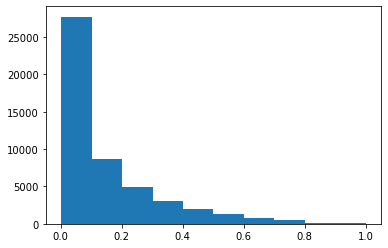

In [24]:
plt.hist(other_combine_difficulity_sort['zigzagness'])

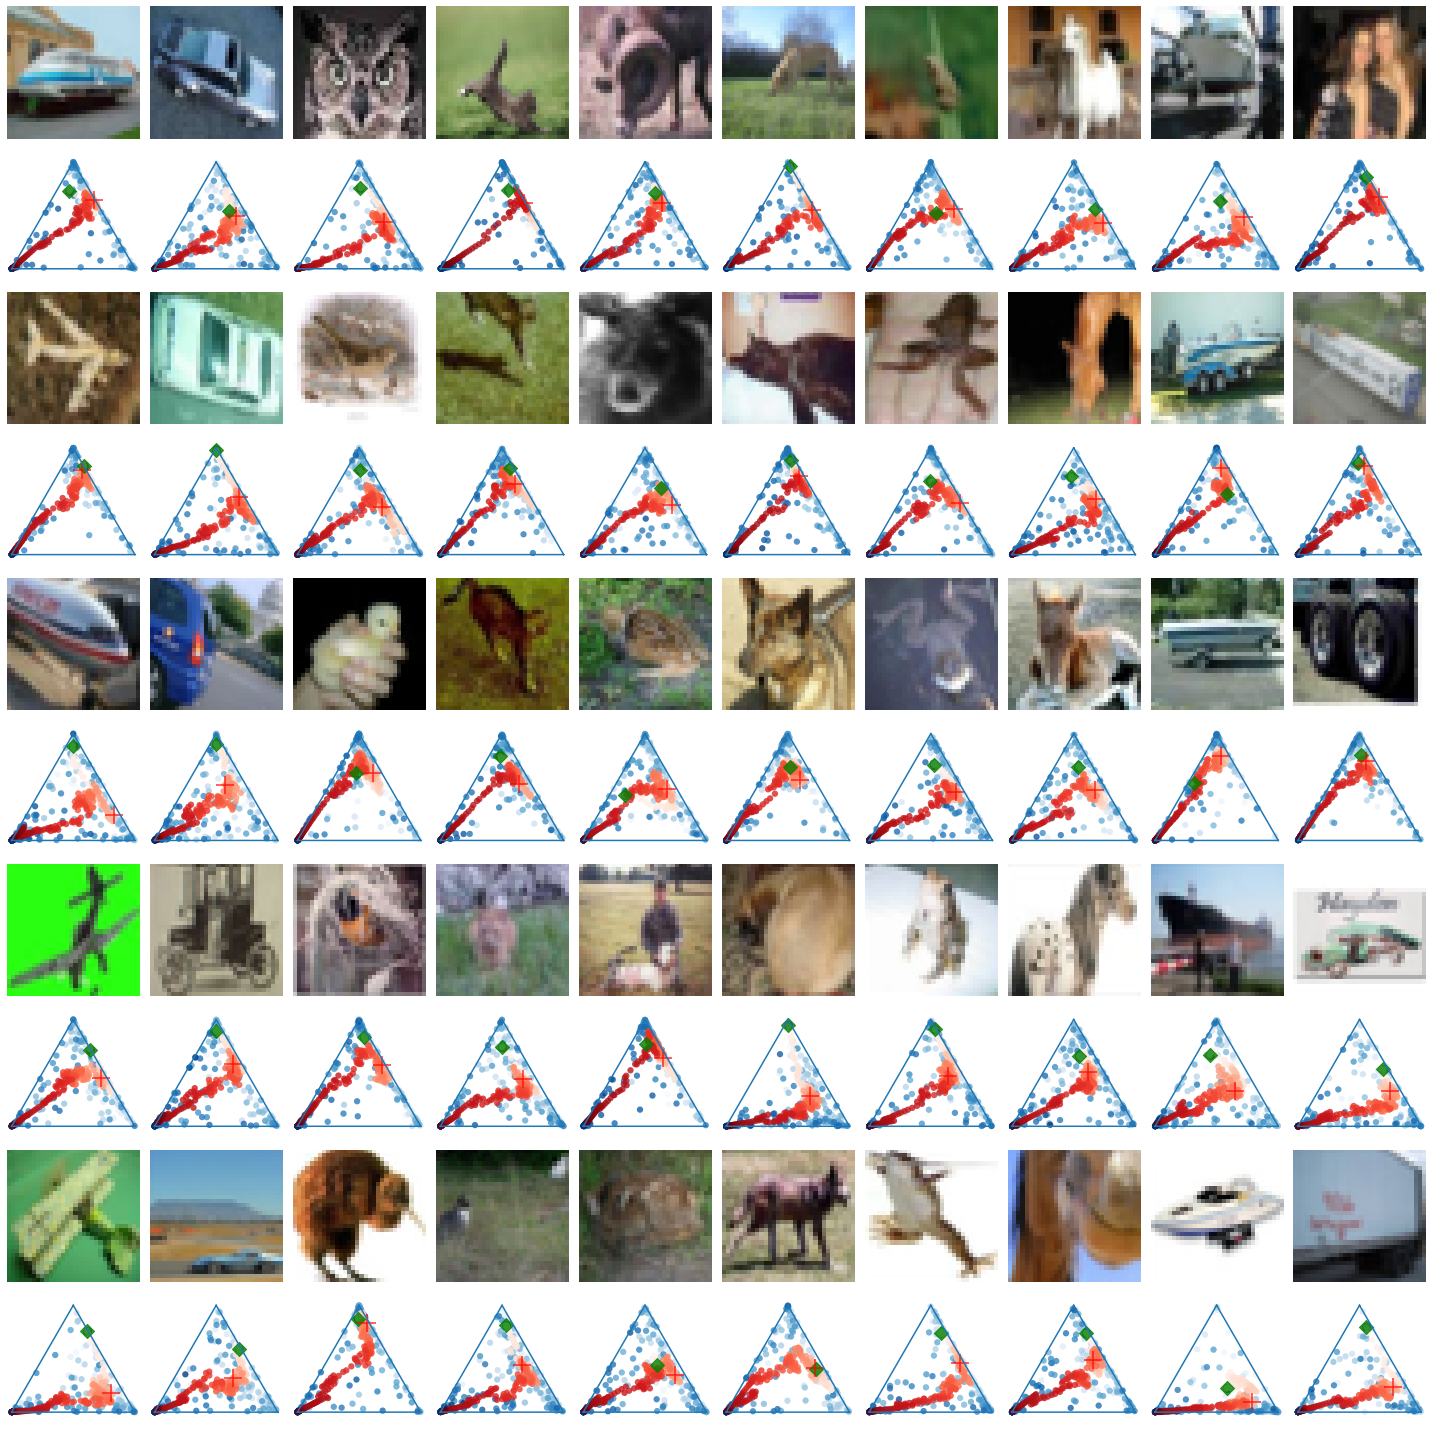

In [25]:
figure, ax = plt.subplots(10,10,figsize=(20,20))
for c in range(10):   # Class
    for r in range(5):  # Sample
        smp_id = r*10+c
        class_mask = other_combine_difficulity_sort['class']==(c)
        img_idx = int(list(other_combine_difficulity_sort[class_mask]['index'])[r])
        img, clas = CIFAR10_Train.__getitem__(img_idx)
        ax[2*r][c].imshow(img.transpose(0,2).transpose(0,1))
        ax[2*r][c].axis('off') 
        draw_one_pic_y_ny(img_idx, smooth_level = 0.9, start_end=[0,200], path_type='clean_label',ax=ax[2*r+1][c],legend=False)
figure.tight_layout()

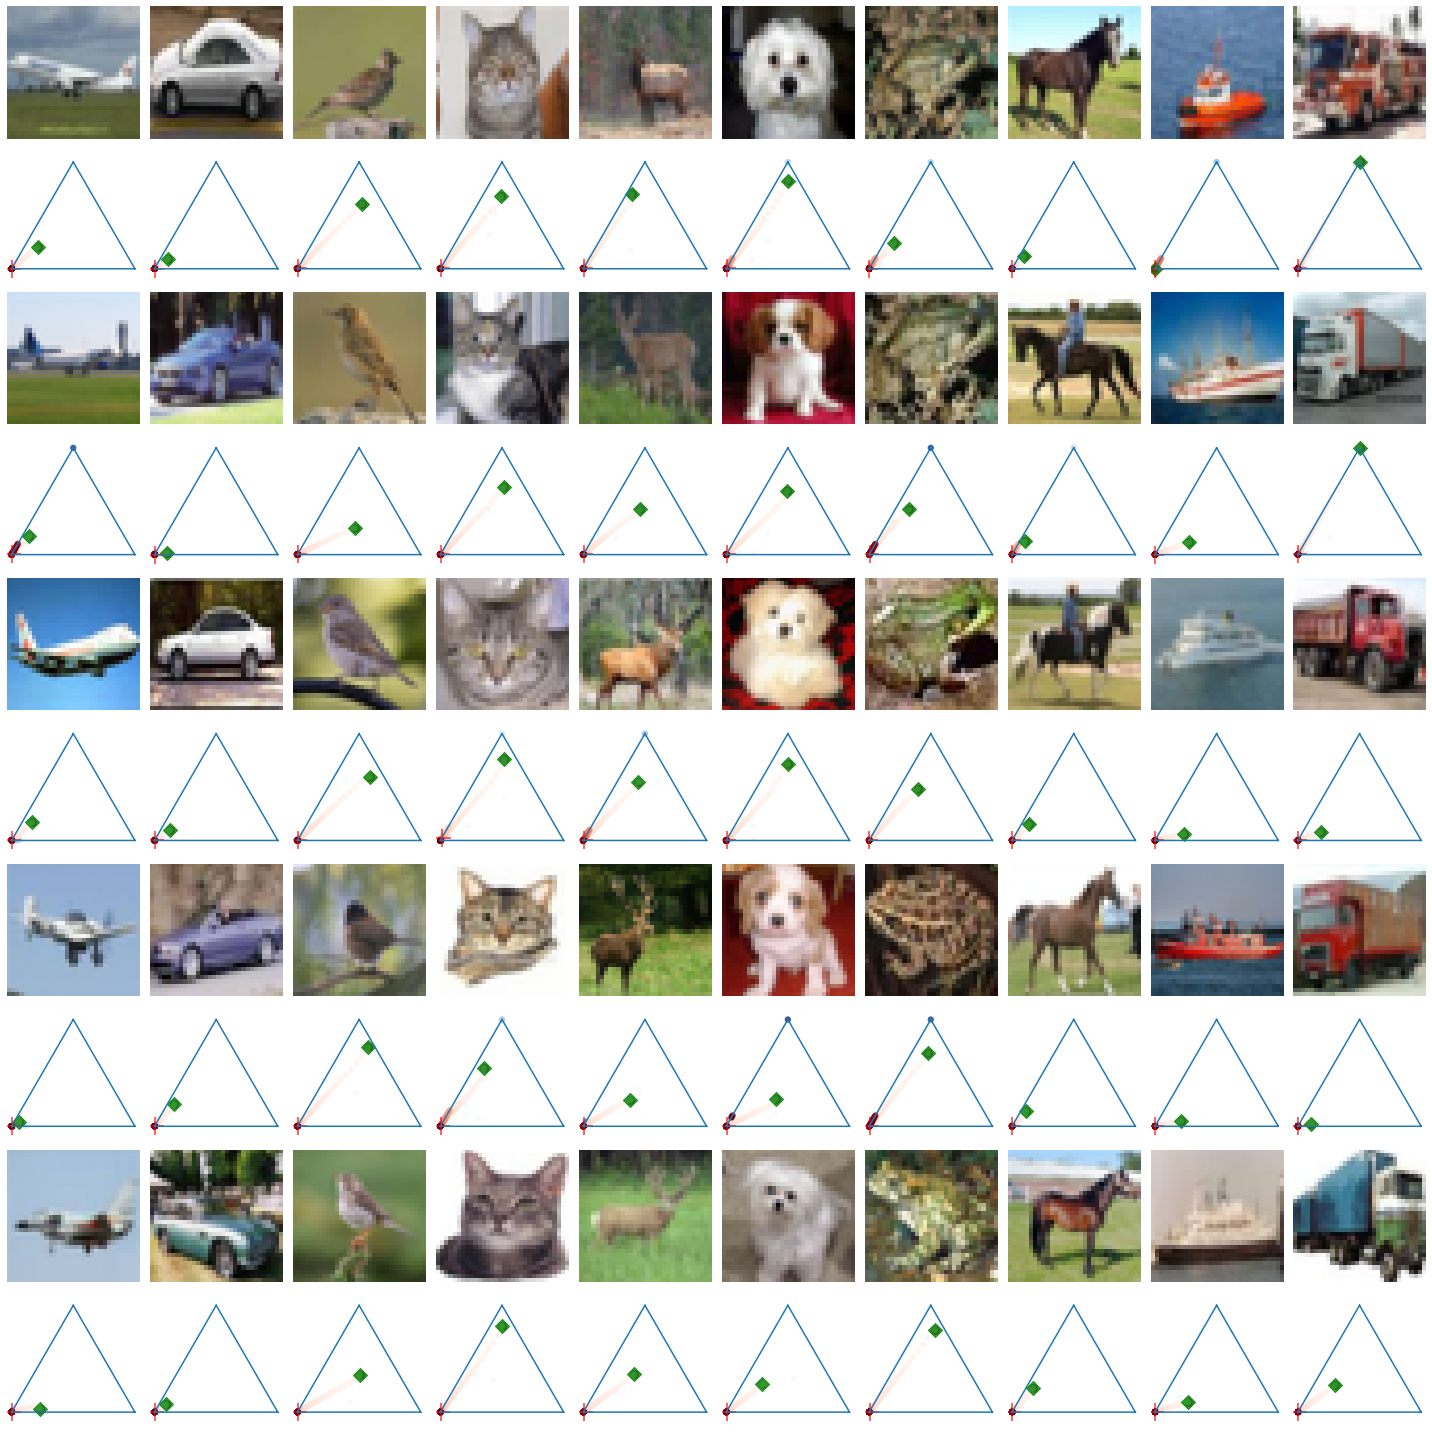

In [26]:
figure, ax = plt.subplots(10,10,figsize=(20,20))
for c in range(10):   # Class
    for r in range(5):  # Sample
        smp_id = r*10+c
        class_mask = other_combine_difficulity_sort['class']==(c)
        img_idx = int(list(other_combine_difficulity_sort[class_mask]['index'])[-r-1])
        img, clas = CIFAR10_Train.__getitem__(img_idx)
        ax[2*r][c].imshow(img.transpose(0,2).transpose(0,1))
        ax[2*r][c].axis('off') 
        draw_one_pic_y_ny(img_idx, smooth_level = 0.9, start_end=[0,200], path_type='clean_label',ax=ax[2*r+1][c],legend=False)
figure.tight_layout()